# Вступление

**Задачей проекта является сведение в одну таблицу данных из трёх разных источников, приведение их в порядок - избавление от возможных пропусков, дубликатов и пр., при необходимости переформатирование данных и иную форму. Целью проекта является изучение рынка аренды самокатов по короткому срезу городов, поиск неявных закономерностей или выбивающихся из ряда явлений, составление клиентского портрета и проверка некоторых гипотез, которые могут улучшить сервис и повысить прибыльность бизнеса.

# Шаг 1. Загрузка данных

## 1.1 Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom, poisson, norm
from math import sqrt, factorial

In [2]:
# создание фреймов из предоставленных данных
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

## 1.2 Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.

In [3]:
users.info()
users.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


* V1
Фрейм users состоит из 5 столбцов, содержащих данные для построения портрета клиента - возраст, место проживания, наличие или отсутствие подписки и пр. Типы данных: строки для имён, названий городов и типа подписок, целочисленные для ИД и возраста, переформатирование не требуется.

In [4]:
rides.info()
rides.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


* V1
Фрейм rides состоит из 4 столбцов, содержит данные о количестве и длительности поездок с привязкой к дате и идентификатору.
Типы данных: целочисленные для ИД, дробные для дистанции и времени аренды, переформатирование требуется для столбца date, т.к. в текущем виде работать с ним как с источником даты-времени будет неудобно.

In [5]:
subscriptions.info()
subscriptions.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


* V1
Фрейм subscriptions состоит также из 4 столбцов, содержит данные о типе подписки, цене за минуту, месячный тариф и за начало поездки. Типы данных: целочисленные для цен, строковый для типа подписки, переформатирование не требуется.

# Шаг 2. Предобработка данных

## 2.1 Приведите столбец date к типу даты pandas.

In [6]:
#переконвертация столбца date в удобоваримый формат datetime
rides['date'] = pd.to_datetime(rides['date'], format='%Y.%m.%d')

In [7]:
rides['date']

0       2021-01-01
1       2021-01-18
2       2021-04-20
3       2021-08-11
4       2021-08-28
           ...    
18063   2021-11-04
18064   2021-11-16
18065   2021-11-18
18066   2021-11-27
18067   2021-12-29
Name: date, Length: 18068, dtype: datetime64[ns]

## 2.2 Создайте новый столбец с номером месяца на основе столбца date.

In [8]:
rides['month_num'] = pd.DatetimeIndex(rides['date']).month

* V2
* проверим, есть ли там другие значения, помимо 2021 года

In [9]:
if '2021' in (rides['date'].dt.to_period('Y')).values:
    print('В таблице данные больше, чем за 1 год!')

* т.к. сообщения не было, делаем вывод, что в срезе данные всё же только за 2021 год.

## 2.3 Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

In [10]:
# проверка на дубликаты и неверные данные в ячейках
users.isna().sum()
users.duplicated().sum()

31

Обнаружены дубликаты числом 31 шт, надо удалять

In [11]:
# удаление дублей
users = users.drop_duplicates()

In [12]:
# проверка на дубликаты и неверные данные в ячейках
rides.isna().sum()

user_id      0
distance     0
duration     0
date         0
month_num    0
dtype: int64

Всё в порядке, пропусков нет

In [13]:
rides.duplicated().sum()

0

Всё в порядке, дублей нет

In [14]:
# проверка на дубликаты и неверные данные в ячейках
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Всё в порядке, пропусков нет

In [15]:
subscriptions.duplicated().sum()

0

Всё в порядке, дублей нет

V2
**Промежуточные итоги:
Была проведена проверка фреймов на ошибки, NaN и неверные данные в ячейках, найден 31 дубль в ДФ users, лишние данные удалены.

# Шаг 3. Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:
    частота встречаемости городов;
    соотношение пользователей с подпиской и без подписки;
    возраст пользователей;
    расстояние, которое пользователь преодолел за одну поездку;
    продолжительность поездок.

### 3.1 частота встречаемости городов

In [16]:
# подсчёт значений в столбце
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

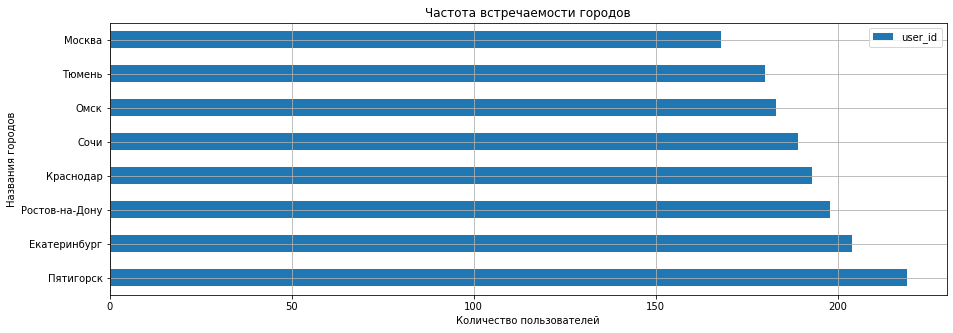

In [17]:
# V1
# построение графика частоты встречаемости городов с ранжиром по возрастанию
df_users = users.pivot_table(index = 'city', values = 'user_id', aggfunc = 'count')
df_users = df_users.sort_values(by='user_id', ascending = False)
df_users.plot( kind='barh', figsize = (15,5), grid = True )
plt.title('Частота встречаемости городов')
plt.xlabel('Количество пользователей')
plt.ylabel('Названия городов')
plt.show()

Всего 8 городов в списке, в каждом из них выборка примерно по 190 пользователей, наименьшее количество их - в Москве, наибольшее - в Пятигорске.

## 3.2 соотношение пользователей с подпиской и без подписки

In [18]:
#V1
# создание сводной таблицы, используя данные из ДФ rides, с группировкой по подписке
df_users_subs = users.pivot_table(index = 'subscription_type', values = 'user_id', aggfunc = 'count').reset_index()

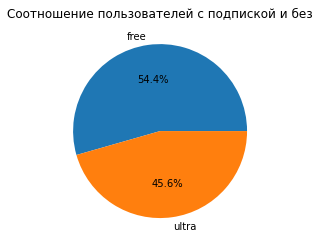

In [19]:
#V1
# отрисовка круговой диаграммы по типам подписки с указанием процентного соотношения
fig, ax = plt.subplots()
ax.pie(df_users_subs['user_id'], labels=df_users_subs['subscription_type'], autopct='%1.1f%%')
plt.title('Соотношение пользователей с подпиской и без')
plt.show()

In [20]:
users['subscription_type'].value_counts()['ultra'] / len(users['subscription_type'])

0.4556714471968709

* пользователи с подпиской составляют 45% от общего числа

### 3.3 возраст пользователей

In [21]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Наименьший возраст клиента - 12 лет, наибольший - 43 года, средний возраст - 24,9 лет.

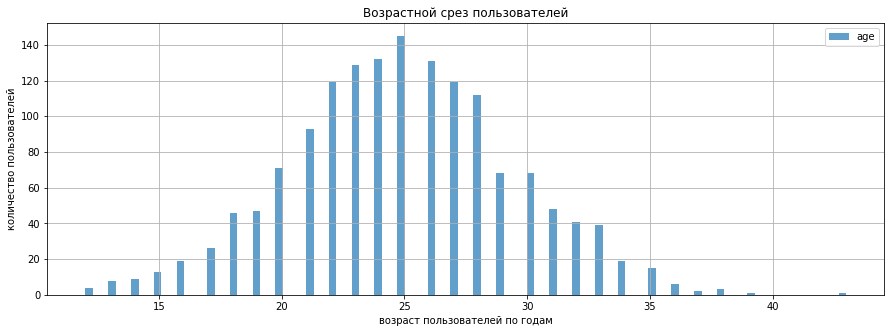

In [22]:
#V2
# построение гистограммы, отражающей кол-во пользователей в зависимости от возраста
users_cut = users['age'].plot(kind='hist', histtype='bar',bins=100,grid=True,alpha=0.7, legend=True,
    title='Возрастной срез пользователей', linewidth=5, figsize = (15, 5)  
                 ).set(xlabel='возраст пользователей по годам', ylabel='количество пользователей')

plt.show()

V2

Как видно из гистограммы, основная масса клиентов расположена в промежутке от 21 до 28 лет, причем их количество снижается быстрее после промежутка, чем возрастает до. Самокат - дело молодых....

### 3.4 расстояние, которое пользователь преодолел за одну поездку

* Построим график для демонстрации дистанции, которую проезжают клиенты

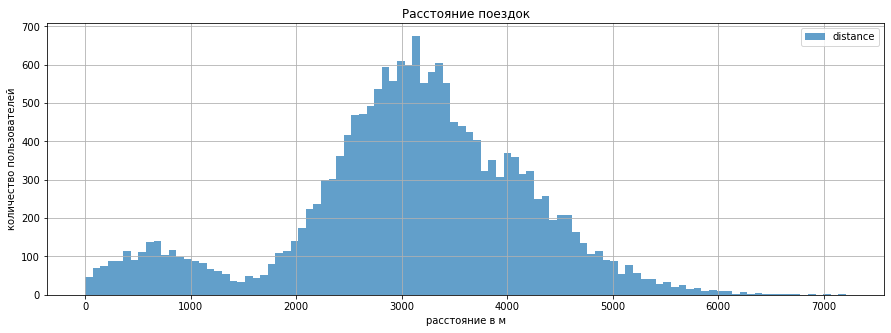

In [23]:
#rides['distance'].hist(bins = 25, figsize = (15, 5))
rides_cut = rides['distance'].plot(kind='hist', histtype='bar',bins=100,grid=True,alpha=0.7, legend=True,
    title='Расстояние поездок', linewidth=5, figsize = (15, 5)  
                 ).set(xlabel='расстояние в м', ylabel='количество пользователей')

plt.show()

In [24]:
rides.groupby('user_id')['distance'].mean()

user_id
1       2839.181839
2       3087.641692
3       3075.633155
4       3202.656423
5       3232.449968
           ...     
1530    2750.498225
1531    2915.425836
1532    2607.861784
1533    2837.707093
1534    3222.957142
Name: distance, Length: 1534, dtype: float64

V2
Судя по графику и по средним значениям, есть две группы наиболее востребованных поездок - в районе 1 и 3 км соотвественно, что условно можно отнести к внутриквартальным и межквартальным (средний предел границ квартала - 4 км), после чего частота резко падает. Некоторый всплеск в районе 600-700 метров можно отнести или к пробным поездкам (кружок-другой по площади), или к просто очень коротким поездкам (деньги есть, а пешком идти лень).

### 3.5 продолжительность поездок

* Построим бокс-диаграмму для понимания продолжительности поездок

<AxesSubplot:>

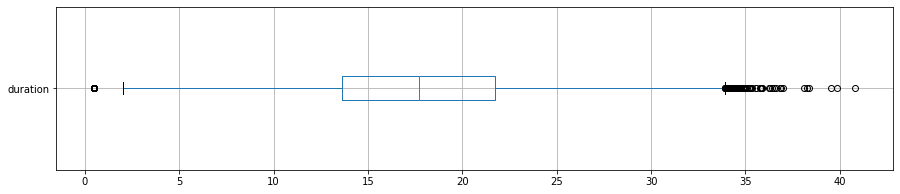

In [25]:
# V1
rides.boxplot(column = 'duration', figsize = (15, 3), vert=False)

* V1

Как видно из распределения, среднее время поездки составляет от 14 до 22 минут, с медианой в районе 17 минут. Редкие выбросы менее 2 минут - это или ошибки аренды (не хватило денег, передумал, низкий заряд и пр), выбросы за границей 30 минут - это или случайные поездки, когда добиратьcя надо, а общественного транспорта или такси поймать не удалось, или аренда с прогулочной\туристической целью.

In [26]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

* V2

Судя по содержимому, самая короткая поездка составила 50 секунд - это, скорей всего, пробный заезд, сама длинная - почти 41 минуту, а в среднем пользователь проезжает чуть менее 18 минут за раз.

#### Шаг 4. Объединение данных

4.1 Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge().

* Поочерёдно присоедненим таблицы на основе общих столбцов

In [27]:
df = users.merge(rides, on='user_id', how='left')

In [28]:
df = df.merge(subscriptions, on='subscription_type', how='left')

In [29]:
#V1 просмотр столбцов на наличие после переноса
df

,user_id,name,age,city,subscription_type,distance,duration,date,month_num,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [30]:
#V1 описание и типы данных в столбцах
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month_num          18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


* V2
* Объединённая таблца состоит из 11 столбцов, строковые параметры - имена пользователей и городов, типы подписок, параметр даты применён именно к столбцу дат, прочие параметры приведены в числовой формат.

In [31]:
#V1
# проверка фрейма на дубли и ошибки
df.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month_num            0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Всё в порядке, дублей нет

In [32]:
#V1
df.duplicated().sum()

0

Всё в порядке, дублей нет

### 4.2 Создайте ещё два датафрейма из датафрейма - c данными о пользователях без подписки; с данными о пользователях с подпиской.

In [33]:
# с подпиской
df_ult = df[df['subscription_type'] == 'ultra']

In [34]:
# без подписки
df_free = df[df['subscription_type'] == 'free']

In [35]:
df_free['duration']

6500     14.944286
6501     16.234663
6502     20.016628
6503      9.782872
6504     17.427673
           ...    
18063    19.822962
18064    21.409799
18065    18.435051
18066    16.674362
18067    15.893917
Name: duration, Length: 11568, dtype: float64

### 4.3 Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

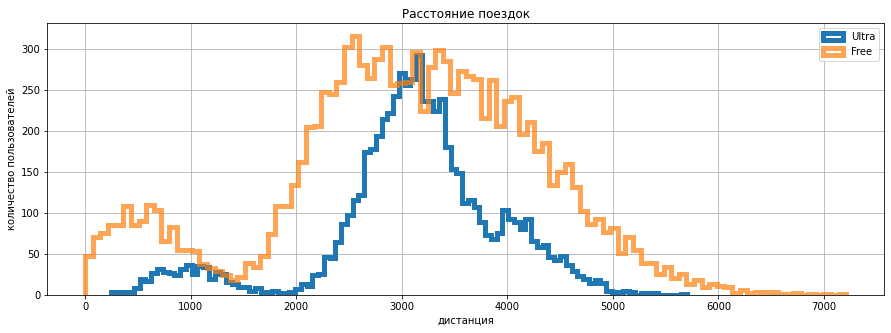

In [36]:
df_ult_hist = df_ult['distance'].plot(kind='hist', y='distance', 
                histtype='step',bins=100,grid=True, legend=True, label='Ultra', alpha=1,
                linewidth=5, figsize = (15, 5)                         
                )
df_free_hist = df_free['distance'].plot(kind='hist', y='distance',
                histtype='step',bins=100,grid=True,alpha=0.7, legend=True, label='Free',
                title='Расстояние поездок', linewidth=5, ax=df_ult_hist, figsize = (15, 5)  
                 ).set(xlabel='дистанция', ylabel='количество пользователей')
plt.show()

* можно предположить, что случайные пользователи предпочитают очень короткие и очень длинные поездки, подписчики же на постоянной основе колесят по одним и тем же маршрутам

* V1

Подписчики категории FREE имеют самый большой разброс в дальности поездок, самые дальние лежат за пределами 7 км. Имеются характерные накопления в районе 500 метров и плато в районе 2.5-3.5 км, из чего можно предположить, что в первом случае спонтанные поездки совершаются, например, до остановок транспорта под влиянием настроения или в случае опозданий, а также до объектов общепита или развлечений, во втором случае расстояние более характерно для внутриквартальных поездок до остановок ОТ.

Подписчики категории ULTRA имеют меньший разброс с характерными пиками в районе 1 и 3 км, что свидетельствует об использовании самокатов для поездок к остановкам ОТ на учёбу или работу, т.к. они совершаются на постоянной основе на одни и те же дистанции, подразумевая рациональное использование платного сервиса. Третий пик в районе 4 км подтверждает это, т.к. за его пределами количество поездок быстро стремится к нулю, а эти 4 км и составляют средний размер одного городского квартала.

Графики весьма сильно отличаются, и, несмотря на схожие пики в районе 1 и 3 км, график FREE имеет большую площадь и большее количество покрываемых вариантов.

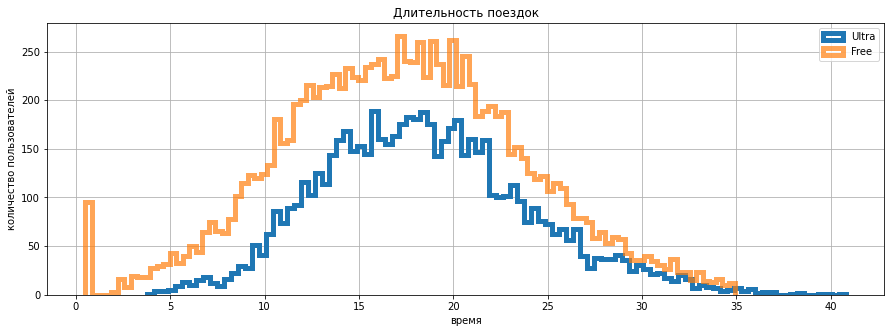

In [37]:
df_ult_hist = df_ult['duration'].plot(kind='hist', y='duration', 
                histtype='step',bins=100,grid=True, legend=True, label='Ultra', alpha=1,
                linewidth=5, figsize = (15, 5)                         
                )
df_free_hist = df_free['duration'].plot(kind='hist', y='duration',
                histtype='step',bins=100,grid=True,alpha=0.7, legend=True, label='Free',
                title='Длительность поездок', linewidth=5, ax=df_ult_hist, figsize = (15, 5)  
                 ).set(xlabel='время', ylabel='количество пользователей')
plt.show()

* V1
Подписчики категории FREE не имеют большого разброса, основная группа сосредоточена в промежутке от 10 до 20 минут (что составляет психологически комфортный диапазон цены "примерно 200 руб") Выброс в диапазоне 0-1 минуты, возможно, свидетельствует об отказе от поездки сразу после регистрации по эмоциональным мотивам ("слишком дорого"). Максимальная длительность поездки - 35 минут.

Подпичики категории ULTRA имеют меньший разброс с характерным плато в районе 15-20 минут,  что свидетельствует об использовании самокатов для поездок к остановкам ОТ на учёбу или работу, т.к. они совершаются на постоянной основе на одни и те же дистанции, и составляют психологически комфортный диапазон цена "примерно 100 руб", при этом они же совершают более длительные  поездки до 45 минут, исходя из принципа "уплачено - должно быть потрачено". 

Графики весьма сильно отличаются, график платной подписки смещён в сторону большей максимальной длительности, но меньшей средней.

#### Шаг 5. Подсчёт выручки

### 5.1 Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [38]:
# продолжительность поездки лучше округлить до целых значений, чем считать сотые доли секунды лишний раз
df['duration'] = np.ceil(df['duration'])
df['duration'] = df['duration'].astype('int')

In [39]:
# а дистанцию - до десятков метров
df['distance'] = df['distance'].round(2)

In [40]:
# создание объединённой таблицы по заданным выше параметрам
df_combo = df.pivot_table(index= ['user_id','name','month_num'], values = ['distance', 'duration'], aggfunc = ['count', 'sum'])
df_combo.columns = ['_'.join(col) for col in df_combo.columns.values]
df_combo = df_combo.drop(columns=['count_duration'])
df_combo = df_combo.reset_index()
display(df_combo)

,user_id,name,month_num,count_distance,sum_distance,sum_duration
0,1,Кира,1,2,7027.51,42
1,1,Кира,4,1,754.16,7
2,1,Кира,8,2,6723.47,46
3,1,Кира,10,2,5809.91,32
4,1,Кира,11,3,7003.50,56
...,...,...,...,...,...,...
11326,1534,Альберт,6,2,3409.47,26
11327,1534,Альберт,8,2,7622.45,48
11328,1534,Альберт,9,1,4928.17,23
11329,1534,Альберт,11,4,13350.02,78


* count_distance - количество поездок за месяц
* sum_distance - суммарное расстояние, которое пользователь проехал за месяц
* sum_duration - суммарная продолжительность поездок за месяц (в минутах)

### Добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26.

In [41]:
df_combo = df_combo.merge(users, how='left', on='user_id')
df_combo = df_combo.merge(subscriptions, how = 'left', on='subscription_type')
display(df_combo)

,user_id,name_x,month_num,count_distance,sum_distance,sum_duration,name_y,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,Кира,1,2,7027.51,42,Кира,22,Тюмень,ultra,6,0,199
1,1,Кира,4,1,754.16,7,Кира,22,Тюмень,ultra,6,0,199
2,1,Кира,8,2,6723.47,46,Кира,22,Тюмень,ultra,6,0,199
3,1,Кира,10,2,5809.91,32,Кира,22,Тюмень,ultra,6,0,199
4,1,Кира,11,3,7003.50,56,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11326,1534,Альберт,6,2,3409.47,26,Альберт,25,Краснодар,free,8,50,0
11327,1534,Альберт,8,2,7622.45,48,Альберт,25,Краснодар,free,8,50,0
11328,1534,Альберт,9,1,4928.17,23,Альберт,25,Краснодар,free,8,50,0
11329,1534,Альберт,11,4,13350.02,78,Альберт,25,Краснодар,free,8,50,0


In [42]:
def profit(row):
  profit_summary = 0
  profit_summary = (row['start_ride_price'] * row['count_distance'] +
              row['minute_price'] * row['sum_duration'] +
              row['subscription_fee']
              )
  return profit_summary

df_combo['profit'] = df_combo.apply(profit, axis=1)
display(df_combo[['user_id', 'name_x', 'month_num', 'profit']])

,user_id,name_x,month_num,profit
0,1,Кира,1,451
1,1,Кира,4,241
2,1,Кира,8,475
3,1,Кира,10,391
4,1,Кира,11,535
...,...,...,...,...
11326,1534,Альберт,6,308
11327,1534,Альберт,8,484
11328,1534,Альберт,9,234
11329,1534,Альберт,11,824


### Шаг 6. Проверка гипотез

## 6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Нужно будет сравнить две выборки, df_ult и df_free, и проверить две гипотезы:
    1. Н0: среднее время поездок пользователей с подпиской и без равны
    2. Н1: время поездок группы пользователей с подпиской больше, чем без подписки

In [43]:
# уровень статистической значимости стандартный
alpha = 0.05
# т.к. принята правосторонняя альтернативная гипотеза, выбирается 'greater'
results = st.ttest_ind(df_ult['duration'], df_free['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Нулевая гипотеза опровергнута')
else:
    print('Нулевая гипотеза не опровергнута')

p-значение: 1.2804098316645618e-34
Нулевая гипотеза опровергнута


In [44]:
print('Среднее время поездки пользователей c подпиской:', round(df_ult['duration'].mean(),2))
print('Среднее время поездки пользователей без подписки:', round(df_free['duration'].mean(),2))

Среднее время поездки пользователей c подпиской: 18.54
Среднее время поездки пользователей без подписки: 17.39


* Согласно вычислениям, пользователи с подпиской тратят больше времени на поездки, что логично, т.к. при длительных и регулярных поездках абонентская плата оказывается выгоднее

## 6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

* V1
Снова сравнение по двум выборкам и набору гипотез:
    1. Н0: среднее расстояние поездок пользователей с подпиской равна 3130 метрам
    2. Н1: среднее расстояние поездок пользователей с подпиской больше 3130 метров

* альт гипотеза изменена исходя из условий, что нарушением является значение interested_value > 3130

In [45]:
# V1
interested_value = 3130 # заданная граничная величина

alpha = 0.05 # стандартный уровень статистической значимости

results = st.ttest_1samp(df_ult['distance'], interested_value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Нулевая гипотеза опровергнута')
else:
    print('Нулевая гипотеза не опровергнута')

p-значение: 0.9195368847849785
Нулевая гипотеза не опровергнута


In [46]:
print('Среднее дистанция поездки пользователей c подпиской:', round(df_ult['distance'].mean(),0))

Среднее дистанция поездки пользователей c подпиской: 3115.0


* V2

Подтверждается, что средняя дистанция поездки пользователи с подпиской меньше 3130 метров.

## 6.3 Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Аналогичные гипотезы и выборки:
    1. Н0: ежемесячная выручка от пользователей с подпиской и без равны.
    2. Н1: ежемесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки

In [47]:
# отдельные сборки по критерию подписки, и проверка гипотезы по критерию прибыли ['profit']
df_agg_ult = df_combo[df_combo['subscription_type'] == 'ultra']
df_agg_free = df_combo[df_combo['subscription_type'] == 'free']

alpha = 0.05 

results = st.ttest_ind(df_agg_ult['profit'], df_agg_free['profit'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Нулевая гипотеза опровергнута')
else:
    print('Нулевая гипотеза не опровергнута')

p-значение: 1.8850394384715216e-31
Нулевая гипотеза опровергнута


In [48]:
print('Средняя помесячная выручка от пользователи с подпиской:', round(df_agg_ult['profit'].mean(),2))
print('Средняя помесячная выручка от пользователи без подписки:', round(df_agg_free['profit'].mean(),2))

Средняя помесячная выручка от пользователи с подпиской: 362.79
Средняя помесячная выручка от пользователи без подписки: 328.64


* Согласно вычислениям, помесячная выручка от подписчиков выше, причём на значиную величину - примерно 10%

## 6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Нужно будет написать обработку для проверки гипотезы о равенстве средних значений для зависимых выборок, для чего в метод scipy.stats.ttest_rel() передать два параметра: наборы данных до обновления и после

*V1

Исходя из задачи, что кол-во должно снизиться значимо, в дело идёт одностороняя альтернативная гипотеза, о том, что истинное среднее генеральной совокупности до изменения больше, чем истинное среднее генеральной совокупности после изменения. Это правостороняя гипотеза, указывается атрибут alternative='greater', уровень статзначимость берётся за 5%, или alpha = 0.05.

#### Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

<BarContainer object of 1001 artists>

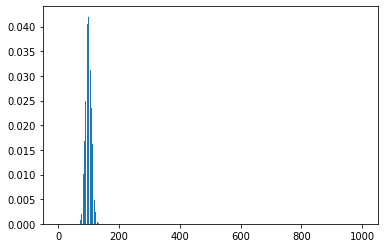

In [49]:
# определение примерного диапазона значений биномиального распределения графиком
n = 1000
p = 0.1
distr = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k)
    distr.append(prob)

plt.bar(range(0, n + 1), distr)

В диапазоне (n-500, n+500) надо определить минимальное количество промокодов, чтобы вероятность провала была не больше 5%

In [50]:
for n in range (500,1500):
    if binom.cdf(99, n, p) < 0.05:
        print("Минимальное число промокодов:", n)
        break

Минимальное число промокодов: 1161


* Вывод: для получения не менее 100 продлений подписок нужно сделать рассылку 1161 промокодов, при стандартной вероятности ошибки в 5%

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [51]:
n = 1000000
p = 0.4

mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma)

x = 399500

result = distr.cdf(x)


print('Вероятность того, что push-уведомления откроют не более 399,5 тыс. пользователей:',
      round(result, 2))

Вероятность того, что push-уведомления откроют не более 399,5 тыс. пользователей: 0.15


* При рассылке 1 млн сообщений вероятность того, что только 399,5 тыс пользователей (чуть меньше половины) откроют сообщение, составляет 15%, т.е. рекламную кампанию в большом приближении можно считать удавшейся

Общий вывод:
    1. при анализе данных в выборке учавствуют всего 8 городов, больше всего пользователей из Пятигорска, меньше всего из Москвы. 
    2. средний возраст пользователя сервиса - 24.9 лет, среднее расстояние большинства поездок чуль больше 3-х километров. Есть небольшой всплеск поездок в райноне 600 метров, можно предположить, что эти поезки совершали пользователи, что бы добраться до станций метро или остановок общественного транспорта. 
    3. Пользователей сервиса аренды самокатов без подписки больше - 54,4%, чем пользователей с подпиской.

В ходе исследования были подтверждены следующие гипотезы:
    1. исходя из результатов проверки гипотезы, можно предположить, что пользователи с подпиской проезжают меньшую дистанцию, нежели пользователи без неё
    2. средняя дистанция поездки пользователи с подпиской меньше 3130 метров (оптимальное расстояние с точки зрения износа самоката)
    3. помесячная выручка от пользователей с подпиской выше чем выручка от пользователей без подписки

Для отдела маркетинга были проведены следующие расчеты:
    1. для акции раздачи промокодов с целью получения не менее 100 продлений подписок нужно сделать рассылку не менее 1161 промокодов
    2. для акции рассылки 1 млн. push-уведомлений вероятность того, что их откроют не более 399,5 тыс. пользователей составляет  15%
  
*V1  
  
Исходя из сравнения графиков дальности поездок и времени поездок можно предположить:
    1. подписчики категории FREE не придерживаются жёстких рамок при использовании ТС ни по дальности, ни по времени, а значительная часть их поездок совершается спонтанно, в т.ч. для развлечения.
    2. подписчики категории ULTRA имеют меньший разброс по дальности и времени, из чего можно предположить, что поездки планируются и совершаются заранее, по одним и тем же маршрутам, на одно и то же расстояние за одно и то же время, т.е. используются именно как транспортное средство с наибольшей эффективностью из соотношения "цена\прибыль" для пользователя, и являются более выгодным сегментом рынка с т.з. амортизации ТС, планирования нагрузки и поступления выручки.